# Regression trainner (make sure mask and the beads matches)

## Cluster function

In [2]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import time

# Ensure the notebook can import the custom U-Net module
cwd = os.getcwd()
custom_unet_dir = os.path.join(cwd, "src", "soil_segment")
if not os.path.exists(os.path.join(custom_unet_dir, "custom_unet.py")):
    custom_unet_dir = os.path.join(os.path.dirname(cwd), "src", "soil_segment")
if os.path.exists(os.path.join(custom_unet_dir, "custom_unet.py")) and custom_unet_dir not in sys.path:
    sys.path.insert(0, custom_unet_dir)
PROJECT_ROOT = Path(custom_unet_dir).resolve().parent.parent
DEFAULT_REGRESSOR_DATASET_DIR = str(PROJECT_ROOT / "datasets" / "regression_dataset")


# Resolve checkpoints directory relative to current working directory
def resolve_checkpoint_path(filename="best_model.pth"):
    search_dir = cwd
    while True:
        candidate = os.path.join(search_dir, "checkpoints", filename)
        if os.path.exists(candidate):
            return candidate
        parent = os.path.dirname(search_dir)
        if parent == search_dir:
            break
        search_dir = parent
    raise FileNotFoundError(f"Checkpoint '{filename}' not found relative to {cwd}")


if '__file__' in globals():
    REPO_ROOT = Path(__file__).resolve().parents[2]
else:
    REPO_ROOT = PROJECT_ROOT
SRC_DIR = REPO_ROOT / "src"

try:
    from soil_segment.custom_unet import SimpleUNet
except ModuleNotFoundError:
    # Support running directly from the repository without `pip install -e .`
    if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
        sys.path.insert(0, str(SRC_DIR))
    from soil_segment.custom_unet import SimpleUNet  # type: ignore

# === FILTER CONFIG ===
BEAD_MASKS = 6             # Number of clusters/classes (excluding background)
CONTRAST_FACTOR = 1       # >1 increases contrast
SATURATION_FACTOR = 1       # >1 increases vividity
BRIGHTNESS_OFFSET = 0      # Offset for brightness adjustment
NUM_CLASSES = None         # Will be inferred from checkpoint

# Check GPU availability
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# === Load U-Net Model ===
def load_unet_model():
    """Load the trained U-Net model and infer its number of classes."""
    checkpoint_path = resolve_checkpoint_path("best_model.pth")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    state_dict = checkpoint.get('model_state_dict', checkpoint)

    if 'final_conv.weight' not in state_dict:
        raise KeyError("Checkpoint is missing 'final_conv.weight'; cannot infer number of classes.")

    num_classes = state_dict['final_conv.weight'].shape[0]
    model = SimpleUNet(in_channels=3, n_classes=num_classes)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(DEVICE)

    global NUM_CLASSES
    NUM_CLASSES = num_classes
    print(f"Loaded U-Net with {NUM_CLASSES} classes.")
    return model
# Initialize model
unet_model = load_unet_model()

# U-Net preprocessing transform
unet_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # must match training size
    transforms.ToTensor(),          # Converts to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # same normalization as training
])

# === Auto-detect image folders ===
def auto_detect_image_folders(base_path=DEFAULT_REGRESSOR_DATASET_DIR):
    """
    Automatically detect all subfolders in the base path that contain images
    
    Args:
        base_path (str or Path): Base directory to search for image folders
    
    Returns:
        list: List of lists containing image paths for each folder
    """
    img_path_list = []

    base_path = Path(base_path)
    candidate_paths = []
    seen = set()

    def _register_candidate(path_candidate):
        path_candidate = Path(path_candidate)
        key = path_candidate.resolve() if path_candidate.exists() else path_candidate
        if key in seen:
            return
        seen.add(key)
        candidate_paths.append(path_candidate)

    _register_candidate(base_path)

    if not base_path.is_absolute():
        _register_candidate(Path(cwd) / base_path)
        _register_candidate(PROJECT_ROOT / base_path)
        _register_candidate(PROJECT_ROOT / "datasets" / base_path)
    else:
        _register_candidate(Path(cwd) / base_path.name)
        _register_candidate(PROJECT_ROOT / base_path.name)
        _register_candidate(PROJECT_ROOT / "datasets" / base_path.name)

    _register_candidate(PROJECT_ROOT / "datasets" / "regression_dataset")

    resolved_base = None
    for candidate in candidate_paths:
        candidate = candidate.expanduser()
        if candidate.exists():
            resolved_base = candidate.resolve()
            break

    if resolved_base is None:
        pretty = base_path if base_path.is_absolute() else base_path.as_posix()
        print(f"Warning: Base path '{pretty}' not found in any known location.")
        return img_path_list

    if not resolved_base.is_dir():
        print(f"Warning: Resolved path '{resolved_base}' is not a directory.")
        return img_path_list

    print(f"Using dataset directory: {resolved_base}")

    subdirs = [p for p in sorted(resolved_base.iterdir()) if p.is_dir()]

    print(f"Found {len(subdirs)} subdirectories in '{resolved_base.name}':")

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    for subdir in subdirs:
        image_files = [p for p in sorted(subdir.iterdir()) if p.suffix.lower() in image_extensions]

        # Support nested "images" directory inside each NPK folder
        if not image_files:
            images_dir = subdir / "images"
            if images_dir.is_dir():
                image_files = [p for p in sorted(images_dir.iterdir()) if p.suffix.lower() in image_extensions]

        if image_files:
            image_paths = [str(p) for p in image_files]
            img_path_list.append(image_paths)
            print(f"  ??? {subdir.name}: {len(image_files)} images")
        else:
            print(f"  ??? {subdir.name}: No images found")

    if not img_path_list:
        print("No valid image folders found.")
    else:
        print(f"Total folders with images: {len(img_path_list)}")

    return img_path_list
# === Load the image paths automatically ===
img_path_list = auto_detect_image_folders("regression_dataset")

if not img_path_list:
    raise FileNotFoundError("No valid image folders found.")

# === Load image to rgb ===
def load_img_as_rgb(img_path):
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === U-Net prediction function ===
def predict_with_unet(image_path, model):
    """
    Use U-Net to predict segmentation masks instead of K-means clustering
    
    Args:
        image_path (str): Path to the input image
        model: Trained U-Net model
    
    Returns:
        numpy.ndarray: Predicted segmentation mask
        numpy.ndarray: Enhanced image for visualization
    """
    # Load and enhance the image
    rgb_image = load_img_as_rgb(image_path)
    
    # Convert enhanced image to PIL for U-Net preprocessing
    enhanced_pil = Image.fromarray(rgb_image.astype(np.uint8))
    
    # Preprocess for U-Net
    input_tensor = unet_transform(enhanced_pil).unsqueeze(0).to(DEVICE)
    
    # Get U-Net prediction
    with torch.no_grad():
        output = model(input_tensor)  # Shape: [1, num_classes, H, W]
    
    # Get predicted mask
    if output.shape[1] == 1:
        # Binary segmentation
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
    else:
        # Multi-class segmentation
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Resize prediction back to original image size
    original_size = rgb_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), 
                                  (original_size[1], original_size[0]), 
                                  interpolation=cv2.INTER_NEAREST)
    
    return pred_mask_resized, rgb_image

# === Segmentation mask extraction (supports CPU and GPU) ===
def get_cluster_mask_gpu(image_path, use_gpu=True):
    """
    Replace K-means clustering with U-Net prediction.

    The function name is kept for compatibility, but it now falls back to
    CPU execution when CUDA is unavailable or `use_gpu` is False.
    Returns masks in order of U-Net class IDs (1 to BEAD_MASKS).
    """
    pred_mask, enhanced_image = predict_with_unet(image_path, unet_model)

    H, W = pred_mask.shape

    all_masks = []
    for class_id in range(1, min(NUM_CLASSES, BEAD_MASKS + 1)):
        class_mask = (pred_mask == class_id)
        all_masks.append(class_mask)

    while len(all_masks) < BEAD_MASKS:
        all_masks.append(np.zeros((H, W), dtype=bool))

    all_masks = all_masks[:BEAD_MASKS]

    return all_masks, enhanced_image


def get_area_gpu(image_path, use_gpu=True):
    """
    Compute per-class pixel areas for a given image mask.

    If a GPU is available and `use_gpu` is True, accumulation runs on CUDA;
    otherwise it falls back to NumPy on the CPU.
    """
    all_masks, enhanced_image = get_cluster_mask_gpu(image_path, use_gpu)

    cluster_areas = []
    use_cuda = bool(use_gpu and torch.cuda.is_available())
    for mask in tqdm(all_masks, desc="Measuring cluster areas"):
        if use_cuda:
            mask_tensor = torch.from_numpy(mask.astype(np.uint8)).to(DEVICE)
            area = int(torch.sum(mask_tensor > 0).item())
        else:
            area = int(np.count_nonzero(mask))
        cluster_areas.append(area)

    return cluster_areas, all_masks, enhanced_image

# === Process all images and return numpy array ===
def process_all_images(use_gpu=True):
    """
    Process all images in img_path_list and return cluster areas as numpy array of shape (n_images, 4)
    
    Args:
        use_gpu (bool): Whether to use GPU acceleration
    
    Returns:
        numpy.ndarray: Array of shape (n_images, 4) containing cluster areas for each image
    """
    all_results = []
    total_images = sum(len(folder_images) for folder_images in img_path_list)
    
    print(f"Processing {total_images} images using {'GPU U-Net' if use_gpu and torch.cuda.is_available() else 'CPU'}")
    print("="*60)
    
    image_counter = 0
    
    for folder_idx, folder_images in enumerate(img_path_list):
        folder_name = f"Folder {folder_idx + 1}"
        print(f"\n{folder_name}: Processing {len(folder_images)} images")
        print("-" * 40)
        
        for img_idx, img_path in enumerate(folder_images):
            image_counter += 1
            # print(f"\n[{image_counter}/{total_images}] Processing: {os.path.basename(img_path)}")
            
            try:
                start_time = time.time()
                
                # Get cluster areas for this image using U-Net
                cluster_areas, _, _ = get_area_gpu(img_path, use_gpu)
                
                if len(cluster_areas) != BEAD_MASKS:
                    print(f"Warning: Expected {BEAD_MASKS} clusters, got {len(cluster_areas)}")
                    # Pad with zeros if needed, or truncate if too many
                    padded_areas = np.zeros(BEAD_MASKS)
                    padded_areas[:min(len(cluster_areas), BEAD_MASKS)] = cluster_areas[:BEAD_MASKS]
                    cluster_areas = padded_areas
                
                all_results.append(cluster_areas)
                
                end_time = time.time()
                # Uncomment the next line to print completion time for each image
                # print(f"Ã¢Å“â€œ Completed in {end_time - start_time:.2f} seconds")
                
            except Exception as e:
                print(f"Ã¢Å“â€” Error processing {img_path}: {str(e)}")
                # Add zeros for failed images to maintain array structure
                all_results.append(np.zeros(BEAD_MASKS))
    
    # Convert to numpy array
    results_array = np.array(all_results)
    
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total images processed: {len(results_array)}")
    print(f"Results shape: {results_array.shape}")
    print(f"Data type: {results_array.dtype}")
    
    return results_array

Using device: cuda
Loaded U-Net with 7 classes.
Using dataset directory: D:\VSC_projects\2D Segment\2D-soil-segment\datasets\regression_dataset
Found 3 subdirectories in 'regression_dataset':
  ??? 13-6-27: 22 images
  ??? 14-7-35: 2 images
  ??? 15-5-20: 2 images
Total folders with images: 3


## Visualization

Preparing visual samples: 100%|██████████| 26/26 [00:56<00:00,  2.17s/it]


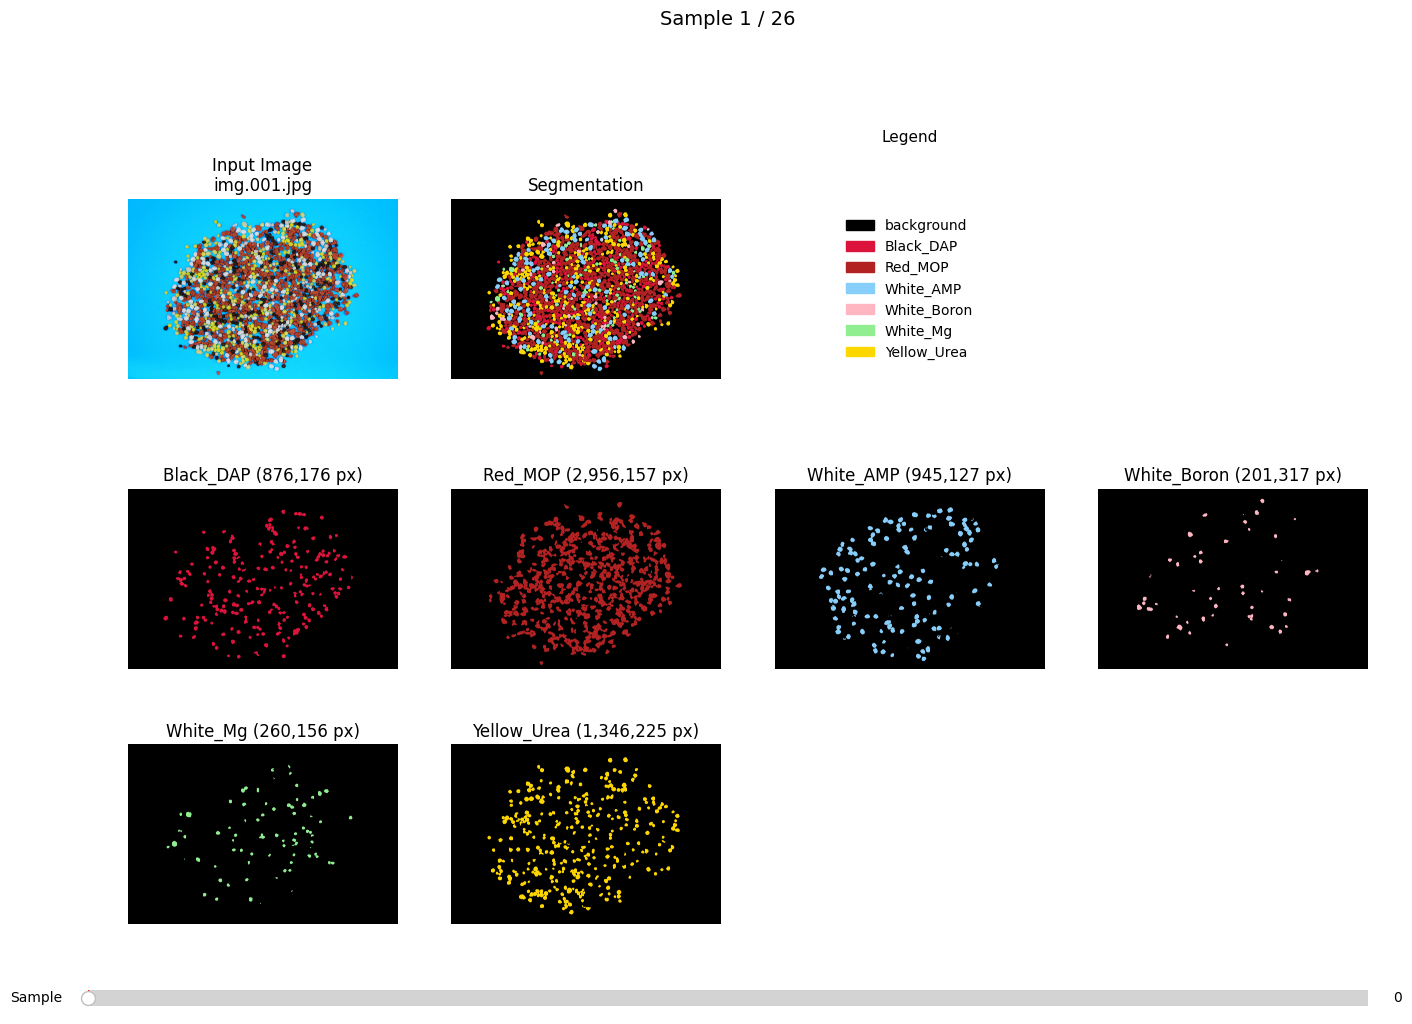


U-Net Prediction Statistics (first sample):
---------------------------------------------
Background: 13376698 pixels
Class 1 (Black_DAP): 876176 pixels
Class 2 (Red_MOP): 2956157 pixels
Class 3 (White_AMP): 945127 pixels
Class 4 (White_Boron): 201317 pixels
Class 5 (White_Mg): 260156 pixels
Class 6 (Yellow_Urea): 1346225 pixels

U-Net Cluster Statistics (first sample):
-----------------------------------
Black_DAP: 876176 pixels
Red_MOP: 2956157 pixels
White_AMP: 945127 pixels
White_Boron: 201317 pixels
White_Mg: 260156 pixels
Yellow_Urea: 1346225 pixels

Processing all images to get cluster areas...


In [3]:

# === Interactive segmentation viewer (similar to visualizer.py) ===
import math
import json
from matplotlib.widgets import Slider
from matplotlib import patches as mpatches

DEFAULT_CLASS_NAMES = (
    "background",
    "Black_DAP",
    "Red_MOP",
    "White_AMP",
    "White_Boron",
    "White_Mg",
    "Yellow_Urea",
)

DEFAULT_CLASS_COLORS = [
    (0, 0, 0),
    (220, 20, 60),
    (178, 34, 34),
    (135, 206, 250),
    (255, 182, 193),
    (144, 238, 144),
    (255, 215, 0),
]


def load_class_names(num_classes):
    class_file = PROJECT_ROOT / "datasets" / "annotate" / "classes.json"
    names = []
    if class_file.exists():
        try:
            data = json.loads(class_file.read_text())
            names = data.get("class_names", [])
        except json.JSONDecodeError:
            pass
    if not names:
        names = list(DEFAULT_CLASS_NAMES)
    if len(names) < num_classes:
        names.extend(f"Class {idx}" for idx in range(len(names), num_classes))
    return names[:num_classes]


if NUM_CLASSES is None:
    raise RuntimeError("NUM_CLASSES not set. Ensure the model is loaded before running the viewer.")

CLASS_NAMES = load_class_names(NUM_CLASSES)
palette = np.array(DEFAULT_CLASS_COLORS, dtype=np.float32) / 255.0
if palette.shape[0] < NUM_CLASSES:
    extra_needed = NUM_CLASSES - palette.shape[0]
    extra_colors = plt.get_cmap("tab20")(np.linspace(0, 1, extra_needed))[:, :3]
    palette = np.vstack([palette, extra_colors])
palette = palette[:NUM_CLASSES]

sample_paths = [path for paths in img_path_list for path in paths]
if not sample_paths:
    raise ValueError("No images available for visualization.")

samples = []
for path in tqdm(sample_paths, desc="Preparing visual samples"):
    image_rgb = load_img_as_rgb(path)
    pred_mask, enhanced_rgb = predict_with_unet(path, unet_model)
    color_mask = np.zeros((*pred_mask.shape, 3), dtype=np.float32)
    for cid in range(NUM_CLASSES):
        color_mask[pred_mask == cid] = palette[cid]
    mask_overlays = []
    mask_binaries = []
    mask_counts = []
    for cid in range(1, NUM_CLASSES):
        class_mask = pred_mask == cid
        overlay = np.zeros_like(color_mask)
        overlay[class_mask] = palette[cid]
        mask_overlays.append(overlay)
        mask_binaries.append(class_mask)
        mask_counts.append(int(class_mask.sum()))
    samples.append(
        {
            "path": path,
            "image": image_rgb.astype(np.float32) / 255.0,
            "prediction": color_mask,
            "mask_overlays": mask_overlays,
            "mask_binaries": mask_binaries,
            "counts": mask_counts,
            "pred_mask": pred_mask,
        }
    )

if not samples:
    raise RuntimeError("Failed to prepare samples for visualization.")

n_masks = NUM_CLASSES - 1
n_cols = max(3, min(4, n_masks if n_masks > 0 else 3))
mask_rows = math.ceil(n_masks / n_cols) if n_masks else 0
total_rows = 1 + mask_rows
height_ratios = [4] + [3] * mask_rows if mask_rows else [4]
fig = plt.figure(figsize=(4 * n_cols, 3 * (total_rows + 0.6)))
gs = fig.add_gridspec(total_rows, n_cols, height_ratios=height_ratios)

ax_image = fig.add_subplot(gs[0, 0])
ax_prediction = fig.add_subplot(gs[0, 1])
legend_col = min(n_cols - 1, 2)
ax_legend = fig.add_subplot(gs[0, legend_col])
for ax in (ax_image, ax_prediction, ax_legend):
    ax.axis("off")

initial_name = Path(samples[0]["path"]).name
image_artist = ax_image.imshow(samples[0]["image"])
ax_image.set_title(f"Input Image\n{initial_name}")

prediction_artist = ax_prediction.imshow(samples[0]["prediction"])
ax_prediction.set_title("Segmentation")


def draw_legend():
    ax_legend.cla()
    ax_legend.axis("off")
    handles = [
        mpatches.Patch(color=palette[idx], label=CLASS_NAMES[idx])
        for idx in range(NUM_CLASSES)
    ]
    legend = ax_legend.legend(handles=handles, loc="center", frameon=False)
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(10)
    ax_legend.set_title("Legend", fontsize=11)
    fig.canvas.draw_idle()


draw_legend()

mask_axes = []
mask_artists = []
if mask_rows:
    for idx in range(n_masks):
        row = 1 + idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        ax.axis("off")
        artist = ax.imshow(samples[0]["mask_overlays"][idx])
        count = samples[0]["counts"][idx]
        class_name = CLASS_NAMES[idx + 1] if (idx + 1) < len(CLASS_NAMES) else f"Class {idx + 1}"
        ax.set_title(f"{class_name} ({count:,} px)")
        mask_axes.append(ax)
        mask_artists.append(artist)


def render_sample(sample_idx: int):
    sample = samples[sample_idx]
    display_name = Path(sample["path"]).name
    image_artist.set_data(sample["image"])
    prediction_artist.set_data(sample["prediction"])
    ax_image.set_title(f"Input Image\n{display_name}")
    for idx in range(n_masks):
        artist = mask_artists[idx]
        mask = sample["mask_overlays"][idx]
        artist.set_data(mask)
        count = sample["counts"][idx]
        class_name = CLASS_NAMES[idx + 1] if (idx + 1) < len(CLASS_NAMES) else f"Class {idx + 1}"
        mask_axes[idx].set_title(f"{class_name} ({count:,} px)")
    fig.suptitle(f"Sample {sample_idx + 1} / {len(samples)}", fontsize=14)
    fig.canvas.draw_idle()


slider_ax = fig.add_axes([0.1, 0.05, 0.8, 0.03])
sample_slider = Slider(
    slider_ax,
    "Sample",
    valmin=0,
    valmax=len(samples) - 1,
    valinit=0,
    valstep=1,
    valfmt="%0.0f",
)


def on_slider(val: float):
    render_sample(int(val))


sample_slider.on_changed(on_slider)


def on_key(event):
    current = int(sample_slider.val)
    if event.key in ("right", "down"):
        sample_slider.set_val(min(len(samples) - 1, current + 1))
    elif event.key in ("left", "up"):
        sample_slider.set_val(max(0, current - 1))


fig.canvas.mpl_connect("key_press_event", on_key)

plt.subplots_adjust(top=0.85, bottom=0.12)
render_sample(0)
plt.show()

# Preserve compatibility for downstream cells
cluster_areas = [samples[0]["counts"][idx] for idx in range(min(BEAD_MASKS, len(samples[0]["counts"]))) ]
all_masks = samples[0]["mask_binaries"][:len(cluster_areas)]

print("\nU-Net Prediction Statistics (first sample):")
print("-" * 45)
unique_classes, class_counts = np.unique(samples[0]["pred_mask"], return_counts=True)
for class_id, count in zip(unique_classes, class_counts):
    if class_id == 0:
        print(f"Background: {count} pixels")
    else:
        class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Class {class_id}"
        print(f"Class {class_id} ({class_name}): {count} pixels")

print("\nU-Net Cluster Statistics (first sample):")
print("-" * 35)
for idx, area in enumerate(cluster_areas, start=1):
    class_name = CLASS_NAMES[idx] if idx < len(CLASS_NAMES) else f"Class {idx}"
    print(f"{class_name}: {area} pixels")

print("\nProcessing all images to get cluster areas...")


## Cluster area generation

In [4]:
cluster_areas_array = process_all_images(use_gpu=True)


Processing 26 images using GPU U-Net

Folder 1: Processing 22 images
----------------------------------------


Measuring cluster areas: 100%|██████████| 6/6 [00:00<00:00, 78.25it/s]



Folder 2: Processing 2 images
----------------------------------------


Measuring cluster areas: 100%|██████████| 6/6 [00:00<00:00, 76.63it/s]



Folder 3: Processing 2 images
----------------------------------------


Measuring cluster areas: 100%|██████████| 6/6 [00:00<00:00, 78.87it/s]


PROCESSING COMPLETE
Total images processed: 26
Results shape: (26, 6)
Data type: int32


In [5]:
print(cluster_areas)

[876176, 2956157, 945127, 201317, 260156, 1346225]


# Data preparation for regression plotting + UNET NPK only predict

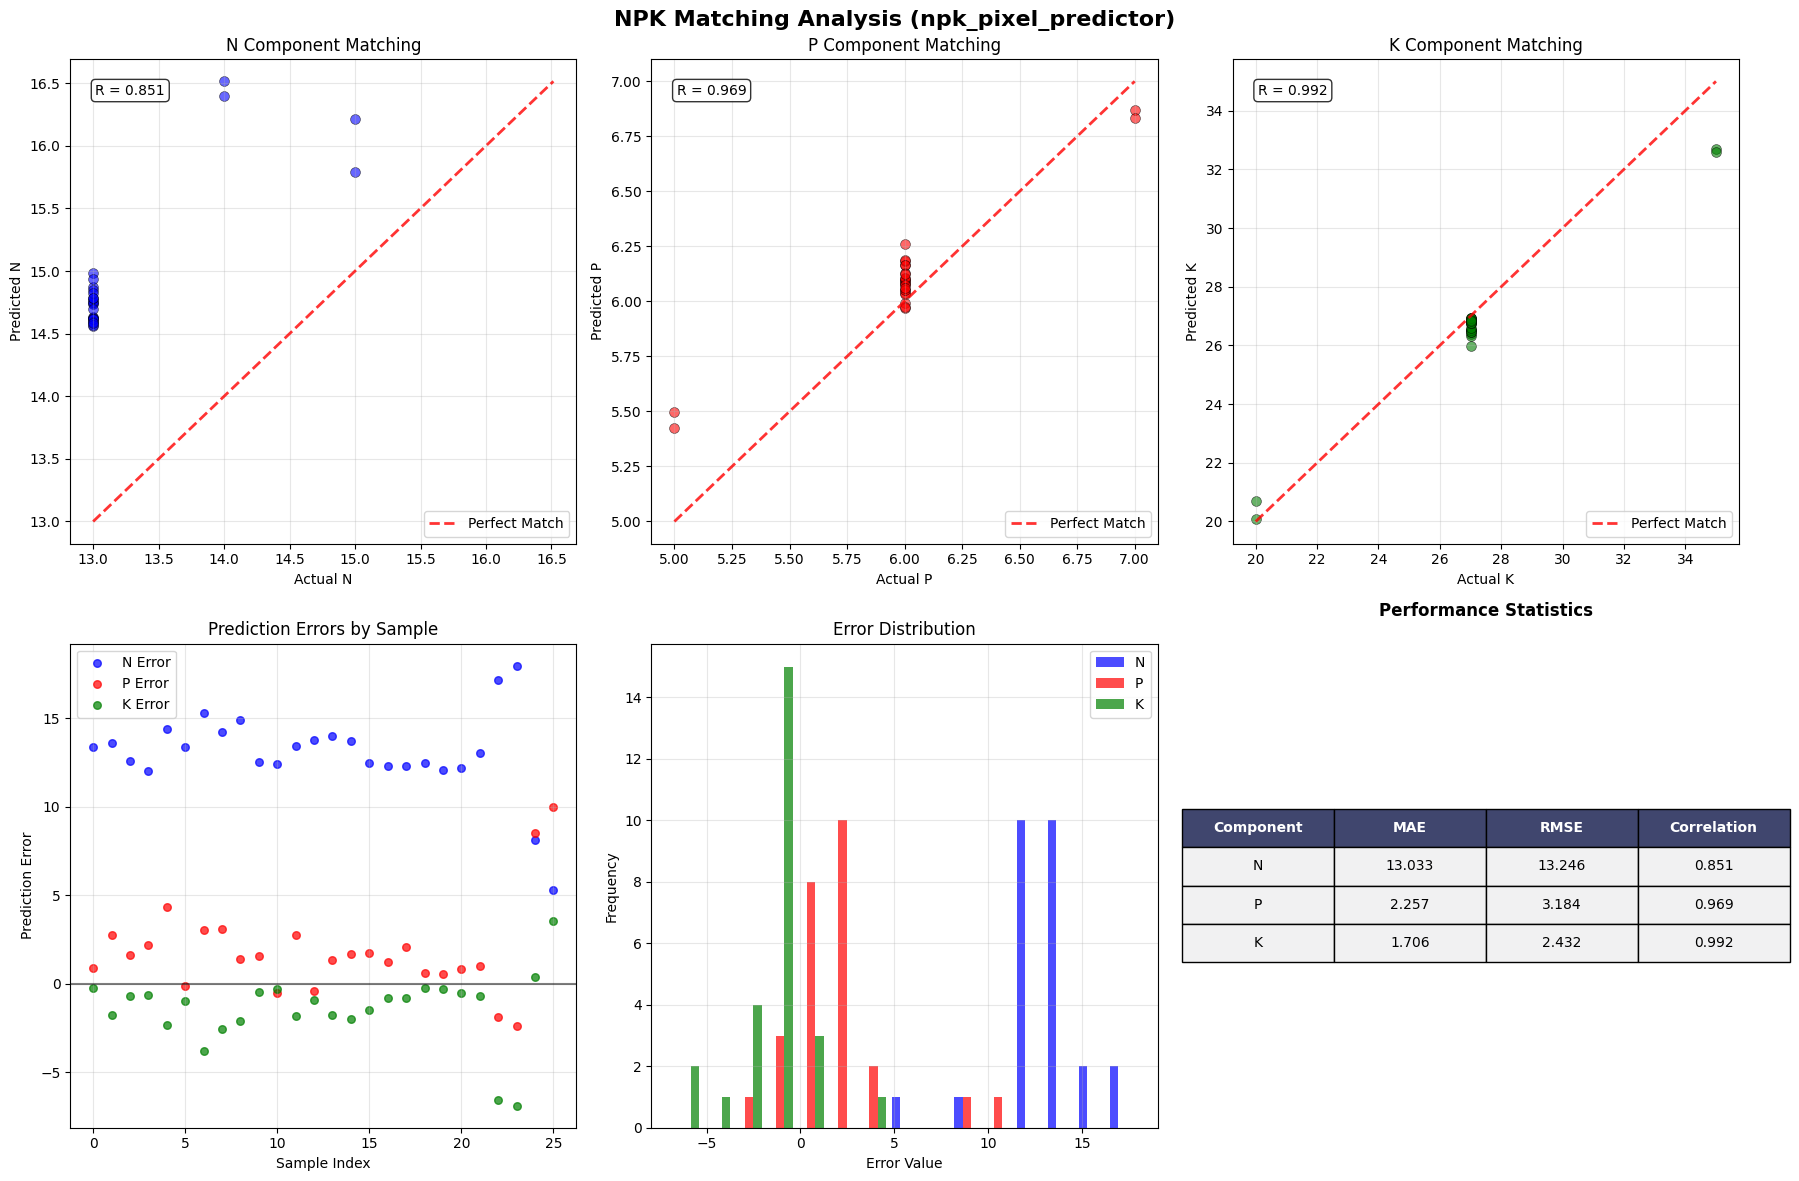


NPK MATCHING ANALYSIS SUMMARY

N Component:
  Mean Absolute Error: 13.033
  Root Mean Square Error: 13.246
  Correlation: 0.851
  Range - Actual: 13.0 to 15.0
  Range - Predicted: 14.562 to 16.515

P Component:
  Mean Absolute Error: 2.257
  Root Mean Square Error: 3.184
  Correlation: 0.969
  Range - Actual: 5.0 to 7.0
  Range - Predicted: 5.426 to 6.871

K Component:
  Mean Absolute Error: 1.706
  Root Mean Square Error: 2.432
  Correlation: 0.992
  Range - Actual: 20.0 to 35.0
  Range - Predicted: 20.082 to 32.709

Sample   Actual NPK                Predicted NPK             Error                    
------------------------------------------------------------------------------------------
1        [13.  6. 27.]             [14.741  6.054 26.935]    [ 1.741  0.054 -0.065]   
2        [13.  6. 27.]             [14.77   6.166 26.52 ]    [ 1.77   0.166 -0.48 ]   
3        [13.  6. 27.]             [14.632  6.099 26.808]    [ 1.632  0.099 -0.192]   
4        [13.  6. 27.]             [

In [6]:

# === Nutrient composition using npk_pixel_predictor ===
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if "samples" not in locals():
    raise RuntimeError("Run the segmentation viewer cell to populate `samples` before computing nutrient composition.")

src_predictions = PROJECT_ROOT / "src"
if str(src_predictions) not in sys.path:
    sys.path.insert(0, str(src_predictions))

try:
    from predictions.npk_pixel_predictor import calculate_nutrient_breakdown, ClassStat
except ModuleNotFoundError:
    if str(PROJECT_ROOT) not in sys.path:
        sys.path.insert(0, str(PROJECT_ROOT))
    from scripts.npk_pixel_predictor import calculate_nutrient_breakdown, ClassStat

def get_npk(cluster_areas, class_names=None):
    """Estimate NPK from class-wise areas using raw-material nutrients."""
    if class_names is None:
        class_names = globals().get("CLASS_NAMES", ("background",))
    background_name = class_names[0] if class_names else "background"
    stats = [ClassStat(idx=0, name=background_name, pixel_count=0, percentage=0.0)]
    for idx, area in enumerate(cluster_areas, start=1):
        name = class_names[idx] if idx < len(class_names) else f"Class {idx}"
        try:
            area_value = float(area)
        except (TypeError, ValueError):
            area_value = 0.0
        if not np.isfinite(area_value) or area_value < 0:
            area_value = 0.0
        stats.append(
            ClassStat(
                idx=idx,
                name=name,
                pixel_count=int(area_value),
                percentage=0.0,
            )
        )
    breakdown = calculate_nutrient_breakdown(stats)
    return [round(float(breakdown.totals[key]), 6) for key in ("N", "P", "K")]

def build_class_stats(mask: np.ndarray, class_names):
    total_pixels = mask.size
    stats = []
    for idx, name in enumerate(class_names):
        pixel_count = int(np.sum(mask == idx))
        percentage = (pixel_count / total_pixels) * 100 if total_pixels else 0.0
        stats.append(ClassStat(idx=idx, name=name, pixel_count=pixel_count, percentage=percentage))
    return stats


per_image_stats = []
nutrient_breakdowns = []
approx_npk = []

for sample in samples:
    stats = build_class_stats(sample["pred_mask"], CLASS_NAMES)
    breakdown = calculate_nutrient_breakdown(stats)
    per_image_stats.append(stats)
    nutrient_breakdowns.append(breakdown)
    approx_npk.append([breakdown.totals["N"], breakdown.totals["P"], breakdown.totals["K"]])

approx_npk = np.array(approx_npk, dtype=np.float32)

X_area = np.array(
    [
        [stats[class_idx].pixel_count if class_idx < len(stats) else 0 for class_idx in range(1, BEAD_MASKS + 1)]
        for stats in per_image_stats
    ],
    dtype=np.int64,
)

def _parse_npk_from_path(path_str):
    p = Path(path_str)
    for candidate in (p.parent, p.parent.parent):
        parts = candidate.name.split("-")
        if len(parts) == 3 and all(part.isdigit() for part in parts):
            return list(map(int, parts))
    raise ValueError(f"Could not parse NPK from path: {path_str}")

actual_npk = np.array(
    [
        _parse_npk_from_path(path)
        for paths in img_path_list
        for path in paths
    ],
    dtype=np.float32,
)

components = ["N", "P", "K"]
colors = ["blue", "red", "green"]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("NPK Matching Analysis (npk_pixel_predictor)", fontsize=16, fontweight="bold")


def _safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return float("nan")
    return np.corrcoef(x, y)[0, 1]


for i, (component, color) in enumerate(zip(components, colors)):
    ax = axes[0, i]
    ax.scatter(actual_npk[:, i], approx_npk[:, i], alpha=0.6, color=color, s=50, edgecolors="black", linewidth=0.5)
    min_val = min(np.min(actual_npk[:, i]), np.min(approx_npk[:, i]))
    max_val = max(np.max(actual_npk[:, i]), np.max(approx_npk[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8, linewidth=2, label="Perfect Match")
    ax.set_xlabel(f"Actual {component}")
    ax.set_ylabel(f"Predicted {component}")
    ax.set_title(f"{component} Component Matching")
    ax.grid(True, alpha=0.3)
    ax.legend()
    correlation = _safe_corr(actual_npk[:, i], approx_npk[:, i])
    label = f"R = {correlation:.3f}" if np.isfinite(correlation) else "R = N/A"
    ax.text(
        0.05,
        0.95,
        label,
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        verticalalignment="top",
    )

ax = axes[1, 0]
errors = approx_npk - actual_npk
denom = np.where(actual_npk == 0, 1, actual_npk)
pct_errors = 100.0 * (approx_npk - actual_npk) / denom
for idx_component, (component, color) in enumerate(zip(components, colors)):
    ax.scatter(range(len(pct_errors)), pct_errors[:, idx_component], label=f"{component} Error", alpha=0.7, color=color, s=30)
ax.axhline(y=0, color="black", linestyle="-", alpha=0.5)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Errors by Sample")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.hist([pct_errors[:, i] for i in range(3)], bins=15, alpha=0.7, label=components, color=colors)
ax.set_xlabel("Error Value")
ax.set_ylabel("Frequency")
ax.set_title("Error Distribution")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.axis("off")

stats_data = []
for i, component in enumerate(components):
    mae = float(np.mean(np.abs(pct_errors[:, i])))
    rmse = float(np.sqrt(np.mean(pct_errors[:, i] ** 2)))
    correlation = _safe_corr(actual_npk[:, i], approx_npk[:, i])
    corr_text = f"{correlation:.3f}" if np.isfinite(correlation) else "N/A"
    stats_data.append([component, f"{mae:.3f}", f"{rmse:.3f}", corr_text])

summary_table = ax.table(
    cellText=stats_data,
    colLabels=["Component", "MAE", "RMSE", "Correlation"],
    cellLoc="center",
    loc="center",
)
summary_table.auto_set_font_size(False)
summary_table.set_fontsize(10)
summary_table.scale(1.2, 2)

for row_idx in range(len(components) + 1):
    for col_idx in range(4):
        cell = summary_table[(row_idx, col_idx)]
        if row_idx == 0:
            cell.set_facecolor("#40466e")
            cell.set_text_props(weight="bold", color="white")
        else:
            cell.set_facecolor("#f1f1f2")

ax.set_title("Performance Statistics", fontweight="bold", pad=20)

plt.tight_layout()
plt.show()

print()
print("=" * 50)
print("NPK MATCHING ANALYSIS SUMMARY")
print("=" * 50)

for i, component in enumerate(components):
    actual_vals = actual_npk[:, i]
    pred_vals = approx_npk[:, i]
    mae = float(np.mean(np.abs(pct_errors[:, i])))
    rmse = float(np.sqrt(np.mean(pct_errors[:, i] ** 2)))
    correlation = _safe_corr(actual_vals, pred_vals)
    corr_text = f"{correlation:.3f}" if np.isfinite(correlation) else "N/A"
    print()
    print(f"{component} Component:")
    print(f"  Mean Absolute Error: {mae:.3f}")
    print(f"  Root Mean Square Error: {rmse:.3f}")
    print(f"  Correlation: {corr_text}")
    print(f"  Range - Actual: {np.min(actual_vals):.1f} to {np.max(actual_vals):.1f}")
    print(f"  Range - Predicted: {np.min(pred_vals):.3f} to {np.max(pred_vals):.3f}")

print()
print(f"{'Sample':<8} {'Actual NPK':<25} {'Predicted NPK':<25} {'Error':<25}")
print("-" * 90)

for idx_sample in range(min(10, len(actual_npk))):
    actual = actual_npk[idx_sample]
    predicted = approx_npk[idx_sample]
    error = predicted - actual
    print(f"{idx_sample + 1:<8} {np.array2string(actual, precision=3):<25} {np.array2string(predicted, precision=3):<25} {np.array2string(error, precision=3):<25}")

if len(actual_npk) > 10:
    print()
    print(f"... and {len(actual_npk) - 10} more samples")


In [7]:
print(f"Number of cluster area samples: {len(X_area)}")
print(f"Number of actual NPK samples: {len(actual_npk)}")

Number of cluster area samples: 26
Number of actual NPK samples: 26


In [8]:
for i in range(len(approx_npk)):
    print(approx_npk[i], actual_npk[i])

[14.741122   6.0539184 26.934725 ] [13.  6. 27.]
[14.770085  6.16636  26.519514] [13.  6. 27.]
[14.632323  6.098991 26.808178] [13.  6. 27.]
[14.561764  6.130439 26.825785] [13.  6. 27.]
[14.870801   6.2604227 26.379473 ] [13.  6. 27.]
[14.739881  5.991719 26.744856] [13.  6. 27.]
[14.984374  6.183099 25.978363] [13.  6. 27.]
[14.847183  6.186988 26.319834] [13.  6. 27.]
[14.93403   6.084836 26.442019] [13.  6. 27.]
[14.625908  6.094341 26.87861 ] [13.  6. 27.]
[14.614455   5.9687686 26.916918 ] [13.  6. 27.]
[14.7488575  6.1663494 26.509987 ] [13.  6. 27.]
[14.785912  5.976307 26.75528 ] [13.  6. 27.]
[14.820956   6.0805893 26.525974 ] [13.  6. 27.]
[14.78532   6.102308 26.463667] [13.  6. 27.]
[14.623567   6.1045327 26.598635 ] [13.  6. 27.]
[14.595771  6.073341 26.777882] [13.  6. 27.]
[14.596695  6.125991 26.780766] [13.  6. 27.]
[14.61857    6.0365586 26.942768 ] [13.  6. 27.]
[14.571255  6.032395 26.927816] [13.  6. 27.]
[14.584615   6.0514565 26.857725 ] [13.  6. 27.]
[14.694135

In [9]:
import numpy as np
import joblib
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression


def _prepare_training_data(approx_features, actual_targets):
    """Validate shapes and cast the NPK arrays used for regression."""
    approx_arr = np.asarray(approx_features, dtype=np.float32)
    actual_arr = np.asarray(actual_targets, dtype=np.float32)
    if approx_arr.shape != actual_arr.shape:
        raise ValueError(
            f"approx_npk shape {approx_arr.shape} does not match actual_npk shape {actual_arr.shape}."
        )
    if approx_arr.ndim != 2:
        raise ValueError("Expected 2D arrays shaped as (n_samples, n_features).")
    return approx_arr, actual_arr


def build_npk_regressor(degree=2, alpha=1.0): # Default
    """Create the polynomial Ridge pipeline used for NPK refinement."""
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression(),
    )


def tune_regressor(y_approx, y_true, save_path=None, degree=2, alpha=1.0): # Default
    """Train a polynomial Ridge regressor and optionally persist it to disk."""
    features, targets = _prepare_training_data(y_approx, y_true)
    regressor = build_npk_regressor(degree=degree, alpha=alpha)
    regressor.fit(features, targets)

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(regressor, save_path)
        print(f"Model checkpoint saved to: {save_path}")

    return regressor


def load_npk_regressor(model_path="checkpoints/regression_model.pkl"):
    """Load a previously saved regression model."""
    model_path = Path(model_path)
    try:
        regressor = joblib.load(model_path)
        print(f"Model loaded from: {model_path}")
        return regressor
    except FileNotFoundError:
        print(f"Model file not found at: {model_path}")
    except Exception as exc:
        print(f"Error loading model: {exc}")
    return None


def predict_npk(regressor, nutrient_features):
    """Run the regression model on nutrient features (e.g., raw NPK estimates)."""
    if regressor is None:
        raise ValueError("Regressor is not loaded.")
    features = np.asarray(nutrient_features, dtype=np.float32).reshape(1, -1)
    return regressor.predict(features).flatten()


def train_regressor_with_holdout(
    y_approx,
    y_true,
    *,
    save_path="checkpoints/regression_model.pkl",
    degree=1,
    alpha=0,
    test_size=0.2,
    random_state=42,
):
    """Train the regressor with a validation split and report hold-out metrics."""
    features, targets = _prepare_training_data(y_approx, y_true)
    if len(features) < 2:
        raise ValueError("Need at least two samples to perform a validation split.")

    x_train, x_val, y_train, y_val = train_test_split(
        features,
        targets,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
    )

    validation_model = build_npk_regressor(degree=degree, alpha=alpha)
    validation_model.fit(x_train, y_train)
    val_predictions = validation_model.predict(x_val)

    val_mae = mean_absolute_error(y_val, val_predictions, multioutput="raw_values")
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions, multioutput="raw_values"))

    final_model = build_npk_regressor(degree=degree, alpha=alpha)
    final_model.fit(features, targets)

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(final_model, save_path)
        print(f"Model checkpoint saved to: {save_path}")

    metrics = {
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "val_sample_count": len(x_val),
    }
    return final_model, metrics, (val_predictions, y_val)


def run_regression_training(approx_npk, actual_npk, **kwargs):
    """Convenience wrapper to train, evaluate, and preview the regressor."""
    regressor, metrics, holdout_results = train_regressor_with_holdout(
        approx_npk,
        actual_npk,
        **kwargs,
    )

    val_predictions, val_actuals = holdout_results
    nutrient_labels = ["N", "P", "K"] if val_predictions.shape[1] == 3 else [
        f"feature_{idx}" for idx in range(val_predictions.shape[1])
    ]

    print("=== Validation metrics ===")
    for label, mae, rmse in zip(nutrient_labels, metrics["val_mae"], metrics["val_rmse"]):
        print(f"{label}: MAE={mae:.4f}, RMSE={rmse:.4f}")

    print(f"Validation samples: {metrics['val_sample_count']}")
    print("=== Sample validation predictions ===")
    preview_count = min(5, len(val_actuals))
    for idx in range(preview_count):
        pred_vec = np.round(val_predictions[idx], 4)
        actual_vec = np.round(val_actuals[idx], 4)
        print(f"{idx + 1:03d} | Predicted: {pred_vec.tolist()} | Actual: {actual_vec.tolist()}")

    return regressor, metrics, holdout_results


try:
    approx_data = approx_npk
    actual_data = actual_npk
except NameError as exc:
    raise RuntimeError(
        "Run the data-prep cell before training the regressor (missing variables: approx_npk, actual_npk)."
    ) from exc

regressor, metrics, holdout_results = run_regression_training(
    approx_data,
    actual_data,
    save_path="checkpoints/regression_model.pkl",
)



Model checkpoint saved to: checkpoints\regression_model.pkl
=== Validation metrics ===
N: MAE=0.1637, RMSE=0.2168
P: MAE=0.0311, RMSE=0.0420
K: MAE=0.1923, RMSE=0.2572
Validation samples: 6
=== Sample validation predictions ===
001 | Predicted: [13.258399963378906, 5.965700149536133, 26.82349967956543] | Actual: [13.0, 6.0, 27.0]
002 | Predicted: [12.901300430297852, 6.008800029754639, 27.03420066833496] | Actual: [13.0, 6.0, 27.0]
003 | Predicted: [13.073100090026855, 6.020100116729736, 27.17840003967285] | Actual: [13.0, 6.0, 27.0]
004 | Predicted: [15.4375, 4.909999847412109, 19.455799102783203] | Actual: [15.0, 5.0, 20.0]
005 | Predicted: [12.975899696350098, 6.005199909210205, 27.03190040588379] | Actual: [13.0, 6.0, 27.0]


Model loaded from: checkpoints\regression_model.pkl


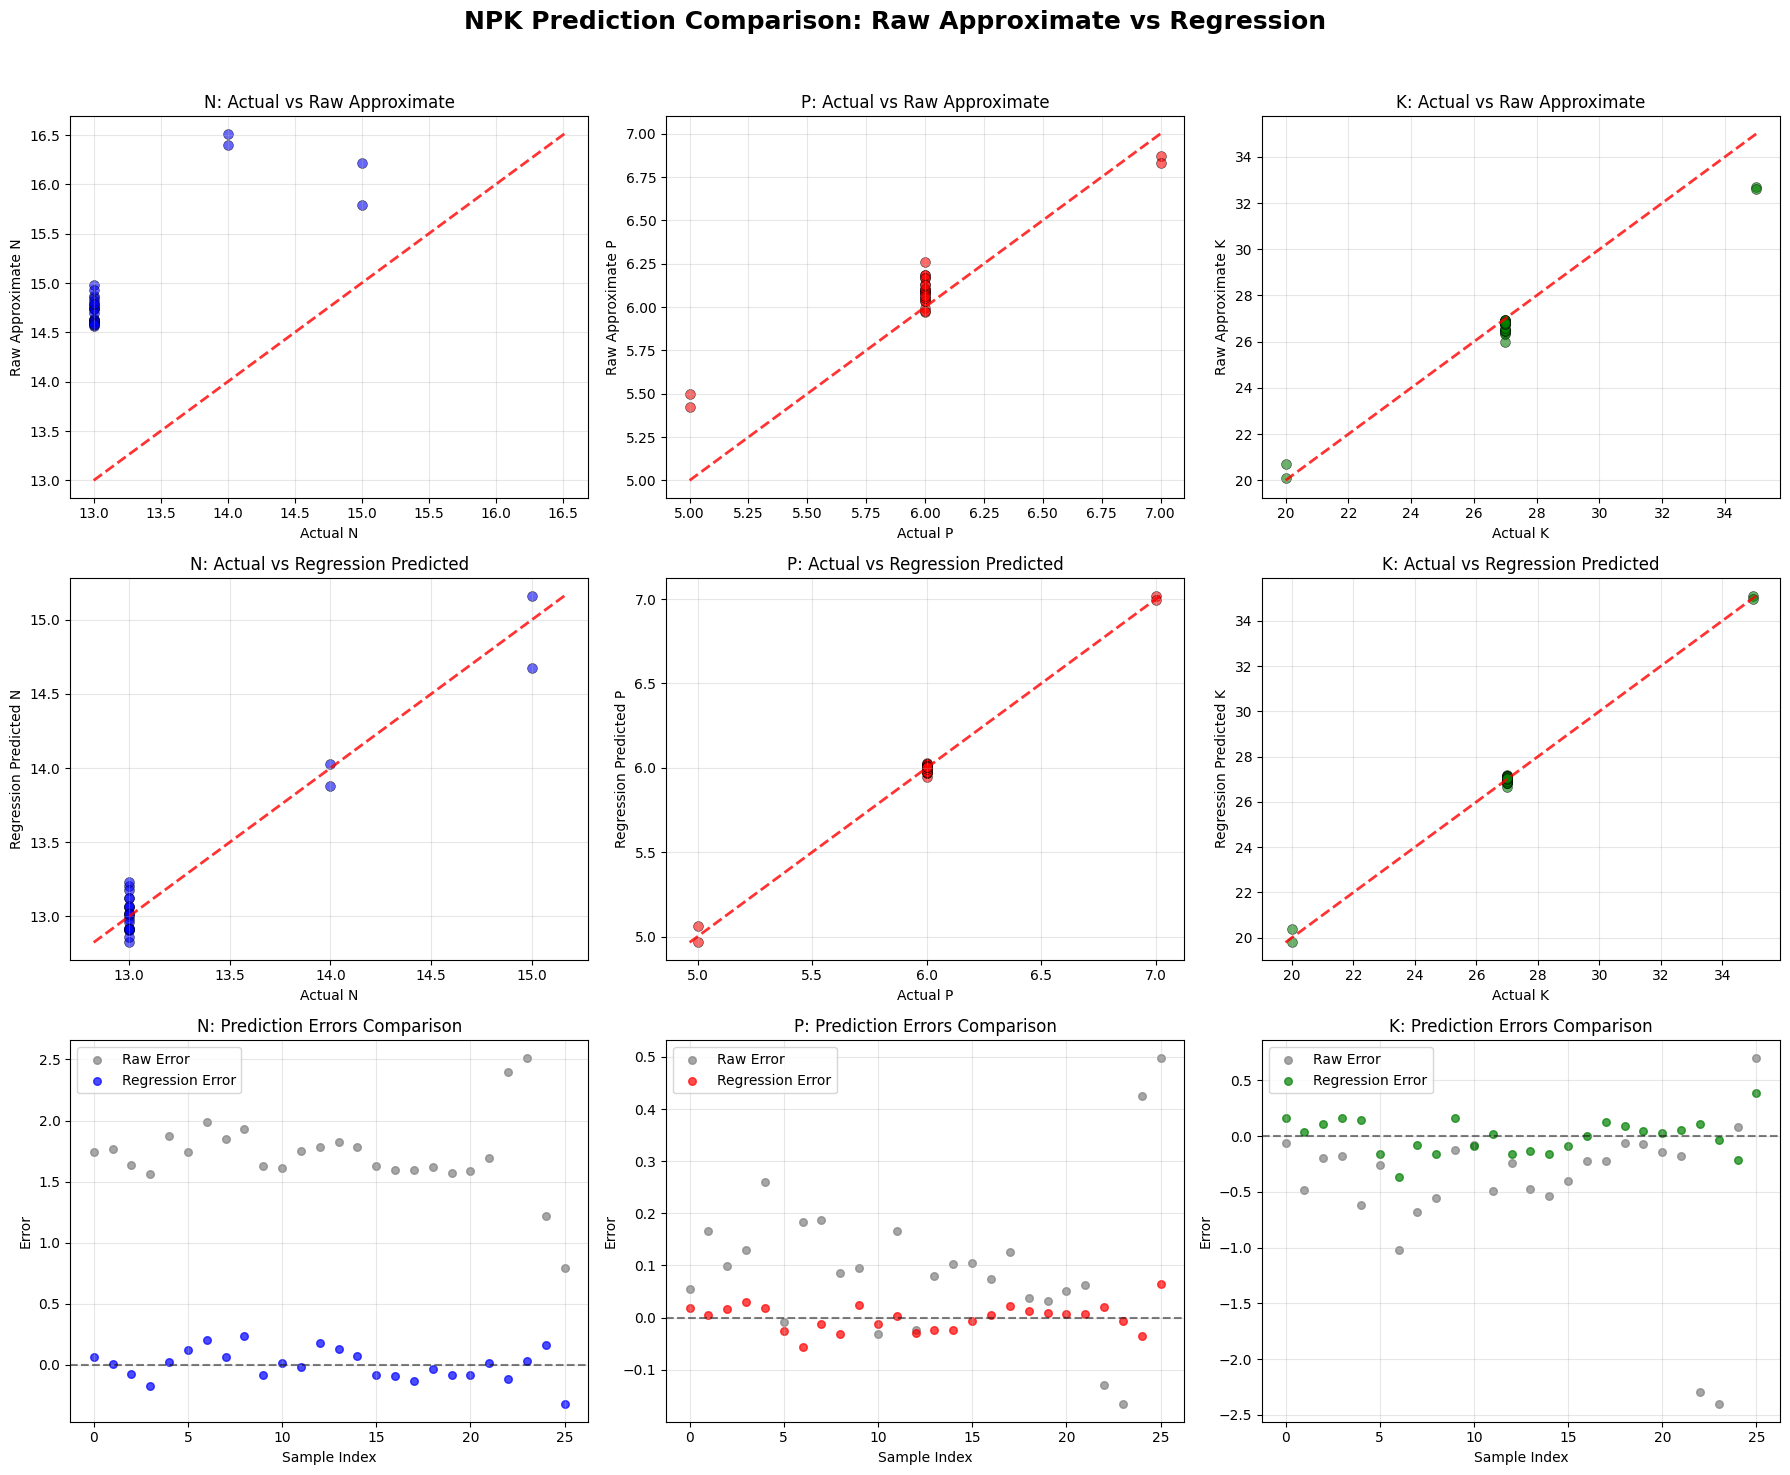

=== Error statistics comparison ===
Component: N
Raw Approximate MAE: 1.718, RMSE: 1.746
Regression Predicted MAE: 0.101, RMSE: 0.126
Component: P
Raw Approximate MAE: 0.130, RMSE: 0.172
Regression Predicted MAE: 0.020, RMSE: 0.025
Component: K
Raw Approximate MAE: 0.491, RMSE: 0.766
Regression Predicted MAE: 0.126, RMSE: 0.155
Detailed per-sample comparison (raw vs regression vs actual):
001 | raw [14.741100311279297, 6.053899765014648, 26.93470001220703] | reg [13.065400123596191, 6.018599987030029, 27.1648006439209] | actual [13.0, 6.0, 27.0]
002 | raw [14.770099639892578, 6.166399955749512, 26.519500732421875] | reg [13.002400398254395, 6.004300117492676, 27.03350067138672] | actual [13.0, 6.0, 27.0]
003 | raw [14.63230037689209, 6.098999977111816, 26.80820083618164] | reg [12.921899795532227, 6.017099857330322, 27.104999542236328] | actual [13.0, 6.0, 27.0]
004 | raw [14.561800003051758, 6.13040018081665, 26.8257999420166] | reg [12.825300216674805, 6.029200077056885, 27.165899276

In [12]:
import numpy as np
import matplotlib.pyplot as plt

REQUIRED_REGRESSION_INPUTS = ("approx_npk", "actual_npk")
missing_helpers = [name for name in ("load_npk_regressor",) if name not in globals()]
if missing_helpers:
    missing_str = ", ".join(sorted(missing_helpers))
    raise RuntimeError(
        f"Run the regression helper cell before evaluating predictions (missing: {missing_str})."
    )

missing_inputs = [name for name in REQUIRED_REGRESSION_INPUTS if name not in globals()]
if missing_inputs:
    missing_str = ", ".join(sorted(missing_inputs))
    raise RuntimeError(
        f"Run the data-prep cell before evaluating the regressor (missing variables: {missing_str})."
    )

regressor = load_npk_regressor('checkpoints/regression_model.pkl')
if regressor is None:
    raise RuntimeError("No saved regressor found. Run the training cell first.")

X_predicted_npk = regressor.predict(approx_npk)  # shape (n_samples, 3)

components = ['N', 'P', 'K']
colors = ['blue', 'red', 'green']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('NPK Prediction Comparison: Raw Approximate vs Regression', fontsize=18, fontweight='bold')

for i, component in enumerate(components):
    # --- 1. Actual vs Raw Approximate ---
    ax = axes[0, i]
    ax.scatter(actual_npk[:, i], approx_npk[:, i], 
               alpha=0.6, color=colors[i], s=50, edgecolors='black', linewidth=0.5)
    min_val = min(np.min(actual_npk[:, i]), np.min(approx_npk[:, i]))
    max_val = max(np.max(actual_npk[:, i]), np.max(approx_npk[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    ax.set_xlabel(f'Actual {component}')
    ax.set_ylabel(f'Raw Approximate {component}')
    ax.set_title(f'{component}: Actual vs Raw Approximate')
    ax.grid(True, alpha=0.3)

    # --- 2. Actual vs Regression Predicted ---
    ax = axes[1, i]
    ax.scatter(actual_npk[:, i], X_predicted_npk[:, i], 
               alpha=0.6, color=colors[i], s=50, edgecolors='black', linewidth=0.5)
    min_val = min(np.min(actual_npk[:, i]), np.min(X_predicted_npk[:, i]))
    max_val = max(np.max(actual_npk[:, i]), np.max(X_predicted_npk[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    ax.set_xlabel(f'Actual {component}')
    ax.set_ylabel(f'Regression Predicted {component}')
    ax.set_title(f'{component}: Actual vs Regression Predicted')
    ax.grid(True, alpha=0.3)

    # --- 3. Error Comparison (Raw vs Regression) ---
    ax = axes[2, i]
    raw_errors = approx_npk[:, i] - actual_npk[:, i]
    reg_errors = X_predicted_npk[:, i] - actual_npk[:, i]
    ax.scatter(range(len(raw_errors)), raw_errors, label='Raw Error', alpha=0.7, color='gray', s=30)
    ax.scatter(range(len(reg_errors)), reg_errors, label='Regression Error', alpha=0.7, color=colors[i], s=30)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Error')
    ax.set_title(f'{component}: Prediction Errors Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Print summary stats for raw and regression ---

def print_stats(errors, label):
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    print(f"{label} MAE: {mae:.3f}, RMSE: {rmse:.3f}")

print("=== Error statistics comparison ===")
for i, component in enumerate(components):
    print(f"Component: {component}")
    raw_errors = approx_npk[:, i] - actual_npk[:, i]
    reg_errors = X_predicted_npk[:, i] - actual_npk[:, i]
    print_stats(raw_errors, "Raw Approximate")
    print_stats(reg_errors, "Regression Predicted")


print("Detailed per-sample comparison (raw vs regression vs actual):")
for i in range(len(actual_npk)):
    raw_vec = np.round(approx_npk[i], 4)
    reg_vec = np.round(X_predicted_npk[i], 4)
    act_vec = np.round(actual_npk[i], 4)
    print(f"{i+1:03d} | raw {raw_vec.tolist()} | reg {reg_vec.tolist()} | actual {act_vec.tolist()}")
